In [1]:
import sys
sys.path.insert(0,'../../../ece219-project4')

from project4.utils.DataIO import DataIO
io = DataIO("../data/cache")

import pandas as pd
import numpy as np

In [2]:
# Silences warnings from sklearn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
from project4.utils.TweetsDataset import TweetsDataset
tweet_data = TweetsDataset()

In [4]:
desired_fields = ['metrics/impressions', 'citation_date', 'author/followers', 'tweet/text', 'tweet/entities']
sampled_tweets = tweet_data.sample_data(400000, desired_fields, 
                                      {"#gohawks": 0.2, "#gopatriots": 0.1, "#nfl":0.2, "#patriots": 0.1, "#sb49":0.2,"#superbowl":0.2},
                                      {"before": 0.2, "during": 0.6, "after": 0.2},
                                      cache_io=io, cache_name="sampled_tweets")

In [5]:
processed_tweets = tweet_data.process_sample(cache_io=io, cache_name="processed_tweets")

In [4]:
tweet_data.get_elapsed_time()

169122it [00:05, 28380.09it/s]
23511it [00:00, 28521.62it/s]
233022it [00:08, 26735.97it/s]
440621it [00:15, 28163.14it/s]
743649it [00:27, 27537.67it/s]
1213813it [00:45, 26912.09it/s]


{'#gohawks': datetime.timedelta(days=24, seconds=7988),
 '#gopatriots': datetime.timedelta(days=23, seconds=79464),
 '#nfl': datetime.timedelta(days=24, seconds=39332),
 '#patriots': datetime.timedelta(days=24, seconds=38862),
 '#sb49': datetime.timedelta(days=24, seconds=23061),
 '#superbowl': datetime.timedelta(days=24, seconds=35221)}

# Question 9.1

In [5]:
average_tweets_by_hashtag = tweet_data.average_tweets_per_hour()

In [6]:
average_tweets_by_hashtag

{'#gohawks': 292.48785062173687,
 '#gopatriots': 40.95469800606194,
 '#nfl': 397.0213901819841,
 '#patriots': 750.89426460689,
 '#sb49': 1276.8570598680474,
 '#superbowl': 2072.11840170408}

In [7]:
average_followers_per_tweet = tweet_data.average_followers()

169122it [00:05, 28769.38it/s]
23511it [00:00, 28285.14it/s]
233022it [00:08, 27260.13it/s]
440621it [00:14, 29674.46it/s]
743649it [00:25, 28739.62it/s]
1213813it [00:44, 27385.17it/s]


In [8]:
average_followers_per_tweet

{'#gohawks': 2217.9237355281984,
 '#gopatriots': 1427.2526051635405,
 '#nfl': 4662.37544523693,
 '#patriots': 3280.4635616550277,
 '#sb49': 10374.160292019487,
 '#superbowl': 8814.96799424623}

In [9]:
average_retweets_per_tweet = tweet_data.average_retweets()

169122it [00:06, 27712.54it/s]
23511it [00:00, 27923.96it/s]
233022it [00:08, 26450.39it/s]
440621it [00:15, 28815.71it/s]
743649it [00:26, 28253.30it/s]
1213813it [00:44, 27280.57it/s]


In [10]:
average_retweets_per_tweet

{'#gohawks': 2.0132093991319877,
 '#gopatriots': 1.4081919101697078,
 '#nfl': 1.5344602655543254,
 '#patriots': 1.7852871288476946,
 '#sb49': 2.52713444111402,
 '#superbowl': 2.3911895819207736}

# Question 9.2

233022it [00:08, 26223.89it/s]


2015-01-14 00:00:04


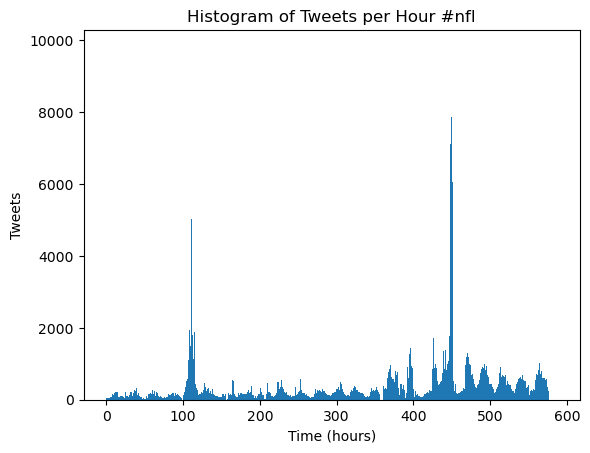

In [11]:
tweet_data.plot_tweets_time_hist("#nfl")

1213813it [00:46, 26115.15it/s]


2015-01-14 00:13:07


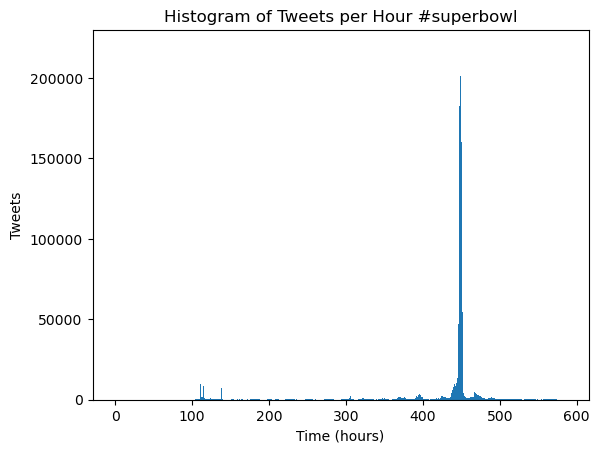

In [12]:
tweet_data.plot_tweets_time_hist("#superbowl")

# Question 10

### Task
Our task is to try and predict how well a tweet will do based on its author, title, content, and hashtags. This can be marked by several metrics that are recorded in this dataset, such as number of retweets, impressions, favorites, comments, etc. These metrics and their documentation can be found here: https://developer.x.com/en/docs/twitter-api/metrics. This falls under the library of prediction tasks. First, we subsample the dataset so that my computer can handle it. We would like to sample some tweets from each hashtag so that the model is well versed. We also need to sample based on the time because there will be very different characteristics before, during, and after the superbowl time period. We will also remove data from the tweet that is not necessary in order to keep the memory requirement lower.

We frame this as a regression problem. Below in the data section we explore what data is available to us and further refine our process.

### Explore Data and Metadata

In [4]:
example = tweet_data.get_a_tweet()

In [5]:
example.keys()

dict_keys(['firstpost_date', 'title', 'url', 'tweet', 'author', 'original_author', 'citation_date', 'metrics', 'highlight', 'type', 'citation_url'])

In [6]:
example['metrics']

{'acceleration': 0,
 'ranking_score': 6.352194,
 'citations': {'influential': 0,
  'total': 4,
  'data': [{'timestamp': 1421517539, 'citations': 1}],
  'matching': 1,
  'replies': 0},
 'peak': 1421517599,
 'impressions': 42,
 'momentum': 1}

Here we can see the data that we could regress on. In order to simplify our target to a single number we will attempt to regress on the impressions field which specifies how many people have seen the tweet, and is not unique by user. We chose this over the total number of citations in order to steer this towards a commercial use case where a brand could know how well an ad would be viewed. Ads are not typically retweeted or interacted with, but the views can still be measured.

In [7]:
example['citation_date']

1421517546

We will have to include some information about the time of the tweet in order to help our model understand the difference between a tweet released 20 days before the superbowl and one at halftime. We will want to sample a higher density of tweets during the superbowl time period to ensure our algorithm learns that crucial time period well.

In [8]:
example['author']

{'author_img': 'http://pbs.twimg.com/profile_images/2817478169/8a1a973fcdc6cb02dbadf4a5ed3d2a7e_normal.jpeg',
 'name': 'Miri',
 'url': 'http://twitter.com/ibrake4flowers',
 'nick': 'ibrake4flowers',
 'followers': 41.0,
 'image_url': 'http://pbs.twimg.com/profile_images/2817478169/8a1a973fcdc6cb02dbadf4a5ed3d2a7e_normal.jpeg',
 'type': 'twitter',
 'influence_level': 7.0,
 'description': 'Have jumped off the high dive, jumped rope, bungee jumped, jumped off a cliff, jumped for joy.'}

Information such as the followers of the author will need to be accounted for by the algorithm. We are trying to narrow down on the text being the independent variable of our experiment, but obviously posts by myself and posts by Rihanna need a different scale for engagement. As such we keep the followers of the author to account for this discrepancy. 

In [9]:
print(example['tweet']['text'])
print(example['tweet']['entities'])

Who do you have?!?! #nfl #NFLPlayoffs #Packers #patriots #broncos #Seahawks #panthers #lions #cardinals #jetsnation http://t.co/pVPrr2DhQh
{'symbols': [], 'media': [{'expanded_url': 'http://twitter.com/NFLplayoffs2015/status/550144662250729472/photo/1', 'sizes': {'large': {'h': 445, 'resize': 'fit', 'w': 576}, 'small': {'h': 262, 'resize': 'fit', 'w': 340}, 'medium': {'h': 445, 'resize': 'fit', 'w': 576}, 'thumb': {'h': 150, 'resize': 'crop', 'w': 150}}, 'url': 'http://t.co/pVPrr2DhQh', 'media_url_https': 'https://pbs.twimg.com/media/B6KBpYsCAAE7CLz.jpg', 'id_str': '550144652494372865', 'indices': [116, 138], 'media_url': 'http://pbs.twimg.com/media/B6KBpYsCAAE7CLz.jpg', 'type': 'photo', 'id': 550144652494372865, 'display_url': 'pic.twitter.com/pVPrr2DhQh'}], 'hashtags': [{'indices': [20, 24], 'text': 'nfl'}, {'indices': [25, 37], 'text': 'NFLPlayoffs'}, {'indices': [38, 46], 'text': 'Packers'}, {'indices': [47, 56], 'text': 'patriots'}, {'indices': [57, 65], 'text': 'broncos'}, {'indi

The text of the tweet is the meat of our algorithm. There will need to be heavy preprocessing done on the text of tweets in order to remove the parts that are not relevant or that are not simple text. Examples include images, user references, hashtags, and urls. Luckily, the tweet data comes with an entities dictionary which helps us find this information and deal with it.

### Feature Selection
We sample the text with a value of 0.2 from each hashtag except since there are two Patriots hashtags they each get 0.1. We also weigh the data to be 0.2 before, 0.2 after, but a majority 60% of the data comes from during the superbowl (with some time buffer). Next we process the data by removing pieces from the entities like media urls, regular urls, and user mentions. Hashtags are placed in a separate field. The hashtags are encoded using a bag of words approach so that if certain hashtags lead to high viewership we can determine that. The resulting text is encoded using GLoVE vectors. This yields our raw features.

In [7]:
processed_tweets[0]

{'metrics/impressions': 5,
 'citation_date': 1421468519,
 'author/followers': 22.0,
 'num_mentioned_users': 0,
 'num_media': 1,
 'num_hashtags': 3,
 'hashtags': 'Seahawks GoHawks 12s',
 'processed_text': '"Oh no big deal, just NFC West Champs and the number 1 seed again" http://t.co/7NigOjTPz2'}

Above is the data that we pull out of each tweet. It may not look like a lot now but after the encoding of the text features there will be a lot of data here.

In [4]:
tweet_data.convert_to_df(io, cache_name="processed_tweets_df")

,metrics/impressions,citation_date,author/followers,num_mentioned_users,num_media,num_hashtags,hashtags,processed_text
0,5,1421468519,22.0,0,1.0,3,Seahawks GoHawks 12s,"""Oh no big deal, just NFC West Champs and the ..."
1,5,1421468336,22.0,0,1.0,1,GoHawks,"Good luck at Michigan, Jim Harbaugh. http://t...."
2,5,1421468144,22.0,0,1.0,3,GoHawks SeahawkLove SoShiny,One of my Favorite Hawk logos that went around...
3,1743,1421425608,1752.0,2,1.0,2,12thMan GoHawks,@teespring My Tee shirt came today!! I love it...
4,4,1421467751,22.0,1,1.0,3,Seahawks GoHawks Beastmode,"Wise Marshawn Lynch, life mottos @MoneyLynch h..."
...,...,...,...,...,...,...,...,...
292955,3352,1423286876,3302.0,0,NaN,4,NewEngland Patriots SuperBowl NFL,LADIES TEE ON SALE!! Champs Ladies Long Sleeve...
292956,49171,1423288838,49323.0,0,NaN,1,SuperBowl,Evidence of Bill Belichick making out with dau...
292957,1,1423289696,1.0,0,1.0,3,GoHawks SuperBowl ArianaGrande,If you needed a reason to root for the Seahawk...
292958,420,1423294025,412.0,0,NaN,6,NFL MVP AaronRodgers Packers SuperBowl Forsale,2005 ULTRA LUCKY 13 #420/599 PSA 10 TRUE RC P...


In [5]:
target = tweet_data.processed_tweets_df['metrics/impressions']
features = tweet_data.processed_tweets_df.drop(columns='metrics/impressions')

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

We use our text preprocessor and GLoVE embedder from a previous project.

In [7]:
from project4.utils.TextPreprocessor import TextPreprocessor
from project4.utils.GloveEmbedder import GloveEmbedder
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
embeddings_dict = io.load("glove.300d.embeddings_dict.pkl")
text_pipe = Pipeline(steps=[
    ("preprocess", TextPreprocessor(n_jobs=-3)),
    ("embed", GloveEmbedder(embeddings_dict, 300, n_jobs=-3)),
    ("dim_reduce", TruncatedSVD(30))
])
normalized_tweet_texts = text_pipe.fit_transform(X_train['processed_text'])
normalized_tweet_texts_test = text_pipe.transform(X_test['processed_text'])

Numerical features are scaled and NaNs are filled with 0s

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_num_features = scaler.fit_transform(X_train[["citation_date", "author/followers", "num_mentioned_users", "num_media", "num_hashtags"]].fillna(0))
scaled_num_features_test = scaler.transform(X_test[["citation_date", "author/followers", "num_mentioned_users", "num_media", "num_hashtags"]].fillna(0))

And the hashtags are vectorized.

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
hashtag_pipe = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(max_df=100)),
    ("dim_reduce", TruncatedSVD(30))
])
hashtags_tfidf = hashtag_pipe.fit_transform(X_train[['hashtags']].to_numpy()[:, 0])
hashtags_tfidf_test = hashtag_pipe.transform(X_test[['hashtags']].to_numpy()[:, 0])

In [56]:
train_final = np.concatenate([scaled_num_features, hashtags_tfidf, normalized_tweet_texts], axis=1)
test_final = np.concatenate([scaled_num_features_test, hashtags_tfidf_test, normalized_tweet_texts_test], axis=1)

In [63]:
from project4.utils.TweetHelper import TweetHelper
tweet_helper = TweetHelper(train_final, test_final, y_train.to_numpy(), y_test.to_numpy())
io.save(tweet_helper, "tweet_helper")

'../data/cache/tweet_helper'

In [64]:
tweet_helper = io.load('tweet_helper')

In [65]:
tweet_helper.data['train']['features']['original'].shape

(234368, 65)

After concatenating all of the features together and saving it in a cache for use later, we are finally done with the feature selection. We will now try several model to attempt to fit this data.

### Baseline

We have chosen Ridge linear regression for the baseline of our next model. By specifying our data in a similar way to the wine dataset we can use some of our code from previous sections.

In [66]:
from project4.utils.TrainingHelper import TrainingHelper

In [67]:
from sklearn.linear_model import Ridge
ridge_space = {
    "alpha": (1e-4, 1e4, 'log-uniform')
}
lin_ridge = TrainingHelper(Ridge(), tweet_helper, 'original')
ridge_est, ridge_results, ridge_rmse = lin_ridge.bayes(ridge_space, 32)

In [68]:
ridge_est

Ridge(alpha=1.7689408843846817)

In [70]:
ridge_rmse

29148.072738808078

Here we have the baseline RMSE to compare our future models against.

### More advanced models

In [71]:
import lightgbm as lgbm
from skopt.space import Integer, Real, Categorical

lgbm_helper = TrainingHelper(lgbm.LGBMRegressor(), tweet_helper, 'original')
lgbm_space = {
    "boosting_type": Categorical(['gbdt', 'dart']),
    "num_leaves": Integer(15, 127, 'uniform'),
    "min_data_in_leaf": Integer(1, 10, 'uniform')
}
lgbm_est, lgbm_results, lgbm_rmse = lgbm_helper.bayes(lgbm_space, n_iter=32)

[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142997 seconds.
You can set `force_col_wise=true` to remove the overhead

Typically, LGBM would be used for more tabular data rather than the features we have crafted from text, but I find it likely that some of the numerical features (such as number of followers and time posted) should be good enough to decide on and make a decent guess. LGBM will pick the most salient features as needed.

In [72]:
lgbm_est

LGBMRegressor(boosting_type='dart', min_data_in_leaf=10, num_leaves=92)

In [76]:
lgbm_results[['mean_fit_time', 'mean_train_score', 'mean_test_score']].median()

mean_fit_time           14.623123
mean_train_score    -47362.470445
mean_test_score    -133687.122363
dtype: float64

In [73]:
lgbm_rmse

124184.28150801173

We see here that our prediction was incorrect and that LGBM was not the correct choice for this type of information. Although the train error is closer to our baseline, the generalization gap is large and causes the model to be unusable for new data. We will also try training an MLP which is much more suitable to this type of data.

In [75]:
from sklearn.neural_network import MLPRegressor

mlp_sklearn = TrainingHelper(MLPRegressor(), tweet_helper, 'original')
mlp_grid = {
    'activation': ['relu'],
    'alpha': [1e-5],
    'hidden_layer_sizes': [[128]]
}
mlp_est, mlp_results, mlp_rmse = mlp_sklearn.grid(mlp_grid)

/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maguire/anaconda3/envs/ece219/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
 

In [77]:
mlp_est

MLPRegressor(alpha=1e-05, hidden_layer_sizes=[128])

In [78]:
mlp_rmse

30832.318891392155

In [79]:
mlp_results[['mean_fit_time', 'mean_train_score', 'mean_test_score']].median()

mean_fit_time         108.205003
mean_train_score   -55744.062241
mean_test_score    -48383.713809
dtype: float64

In [81]:
np.mean(y_train)

8503.991445077827

In [82]:
np.std(y_train)

161148.58574288306

Here we see much closer results to our linear regression baseline. and a smaller generalization gap. I believe the an MLP is the correct model to apply in this scenario and there are lots of hyper parameters in our process that we could have tuned (such as the dimension reduction of text embeddings). However, my computer is not powerful enough to run and train the kind of model and parameter search needed here with such a large dataset. For now, the best model we have is the ridge regression model. However, when we look at the statistics of the dataset, an RMSE of 29k is actually not that bad. Future improvements could be looking at what kind of data has the highest RMSE and sampling more data with those characteristics, increasing complexity of the model, and creating a more complicated preprocessing and feature selection process with hyperparameter tuning.